Download the necessary libraries.

Link to data - https://raw.githubusercontent.com/DataSlingers/clustRviz/master/data/authors.rda

Install these if necessary.

In [ ]:
# %pip install scikit-learn --quiet
# %pip install adjustText --quiet

In [145]:
## Basics
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## ML Packages
import umap
from sklearn.decomposition import FastICA, NMF, KernelPCA, PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import SpectralEmbedding

## Msc
from adjustText import adjust_text
from itertools import combinations

Load dataset.

In [146]:
df = pd.read_csv('authors.csv').rename(columns = {'Unnamed: 0': 'Author'}).drop(columns = 'BookID')
df

,Author,a,all,also,an,and,any,are,as,at,...,was,were,what,when,which,who,will,with,would,your
0,Austen,46,12,0,3,66,9,4,16,13,...,40,11,7,5,6,8,4,9,1,0
1,Austen,35,10,0,7,44,4,3,18,16,...,27,13,5,7,7,3,5,14,8,0
2,Austen,46,2,0,3,40,1,13,11,9,...,24,6,10,4,6,4,5,15,3,9
3,Austen,40,7,0,4,64,3,3,20,13,...,26,10,3,6,10,5,3,22,4,3
4,Austen,29,5,0,6,52,5,14,17,6,...,23,5,8,4,13,2,4,21,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,Shakespeare,32,4,0,6,33,0,7,8,4,...,0,1,13,2,3,3,11,17,5,10
837,Shakespeare,16,5,0,5,49,1,6,10,3,...,1,1,6,5,6,0,11,20,2,7
838,Shakespeare,22,15,0,3,48,0,9,10,2,...,4,0,16,2,2,0,12,15,1,10
839,Shakespeare,25,4,0,8,59,3,6,7,3,...,3,4,11,2,2,2,22,23,4,5


In [147]:
book_id = df['Author']
book_id.value_counts() # 4 different books ; w/ 317 - Austen, ..., 55 - Milton.

Author
Austen         317
London         296
Shakespeare    173
Milton          55
Name: count, dtype: int64

- Unsupervised learning: drop columns ['Authors'] and determine patterns with words across chapters using unsupervised learning methods.

- We will later come back to these labels we dropped to validate our results.

- Note, a row represents a book chapter with each column representing the word counts of key words in that chapter.

In [148]:
X = df.copy().drop(['Author'], axis=1)
X

,a,all,also,an,and,any,are,as,at,be,...,was,were,what,when,which,who,will,with,would,your
0,46,12,0,3,66,9,4,16,13,13,...,40,11,7,5,6,8,4,9,1,0
1,35,10,0,7,44,4,3,18,16,9,...,27,13,5,7,7,3,5,14,8,0
2,46,2,0,3,40,1,13,11,9,23,...,24,6,10,4,6,4,5,15,3,9
3,40,7,0,4,64,3,3,20,13,20,...,26,10,3,6,10,5,3,22,4,3
4,29,5,0,6,52,5,14,17,6,16,...,23,5,8,4,13,2,4,21,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,32,4,0,6,33,0,7,8,4,18,...,0,1,13,2,3,3,11,17,5,10
837,16,5,0,5,49,1,6,10,3,24,...,1,1,6,5,6,0,11,20,2,7
838,22,15,0,3,48,0,9,10,2,13,...,4,0,16,2,2,0,12,15,1,10
839,25,4,0,8,59,3,6,7,3,13,...,3,4,11,2,2,2,22,23,4,5


# PCA

## PCA on Observations

Observations == Book Chapters in [0,1,...,840]

Each observation (point) is a book chapter.

- Using PCA to reduce high-dimensional word frequency data to 2D: PC1 vs PC2.

- The color (hue) is the true author (used only for validation, not in PCA itself).

- The plot helps explore clustering structure among chapters based on word usage.

- This visualization helps show how different writing styles or vocabularies might naturally separate across authors in an unsupervised way.

In [149]:
# Center the features
scaler = StandardScaler(with_std=False) #not scaling only centering
X_centered = scaler.fit_transform(X)

# Perform PCA on scaled data
pca = PCA()
pca_result = pca.fit_transform(X_centered)

pca_df = pd.DataFrame(pca_result)
cols = [f'PC{j+1}' for j in range(pca_df.shape[1])]
pca_df = pca_df.rename(columns = {i:cols[i] for i in range(pca_df.shape[1])})
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
0,-2.265044,43.499301,5.196950,-2.333575,23.359407,22.309224,13.585777,-0.891477,-2.178907,0.062718,...,-2.043904,-3.175850,1.578725,-2.575981,1.463553,-1.107755,-0.341962,2.639943,3.214014,-0.594109
1,-2.604648,25.086417,-9.488717,7.748273,19.244916,1.052493,6.765152,3.650037,-0.746511,-1.753312,...,-2.269775,0.991903,0.013898,1.037391,-1.077602,0.044514,-1.312650,0.800142,0.183083,-0.194564
2,-33.199533,8.667765,-14.833418,3.971572,-6.913595,4.173856,7.094662,-11.728066,1.002140,-4.270366,...,-2.055041,0.864406,-2.179206,2.564626,-3.672920,0.798756,-0.664101,-1.319190,-0.493611,0.165242
3,8.098653,21.760546,6.962558,6.683136,15.262020,7.640936,11.974431,-5.748289,-1.011280,-4.502115,...,0.590874,0.830834,-1.969229,0.937902,-3.603491,-1.244561,1.283435,-0.912942,-0.271062,-0.743841
4,10.031814,6.801164,0.035520,22.731646,10.465248,-5.248171,7.489147,-6.171808,-9.885234,-14.616535,...,1.616164,2.706626,-0.708168,-1.272716,-0.278721,-1.525001,1.746847,-1.004067,-1.272581,-0.229321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,-64.400961,-28.132705,-21.267908,0.131106,-0.337083,12.068621,-5.848328,3.920184,-7.233151,0.239586,...,-0.089364,-0.674634,-1.165301,-0.470178,-1.348415,-0.240363,0.167233,0.514576,-0.123753,-0.036760
837,-58.313001,-23.417273,4.887866,2.462693,-1.275957,-2.603434,-11.452006,4.745220,7.397146,-1.948260,...,-0.264725,-1.237238,-0.170168,1.335993,0.455795,0.942986,-0.266152,-2.256417,-0.182997,-0.021365
838,-47.898865,-31.938566,-7.364020,-9.133520,10.442357,14.851150,-10.872174,10.228351,-5.141056,3.876664,...,0.938558,1.771321,1.542836,-1.795202,1.242780,2.648138,-0.017259,-2.002290,0.787364,0.071339
839,-39.844905,-29.936659,0.614003,-2.261258,5.007836,14.369278,-3.165040,3.620264,1.479972,2.361646,...,-0.011889,1.010582,1.514307,-0.011713,1.135751,0.803847,-0.028491,-0.803976,-1.307802,-0.026705


Let us visualize some of these high variance patterns.

In [150]:
df2, pca_df_with_author = df.copy(), pca_df.copy()
authors = list(df2['Author'].unique())
authors_encoded = {authors[i]:i for i in range(len(authors))}
df2['Author_encoded'] = df2['Author'].apply(lambda x: authors_encoded[x])
pca_df_with_author['Author'] = df2['Author']


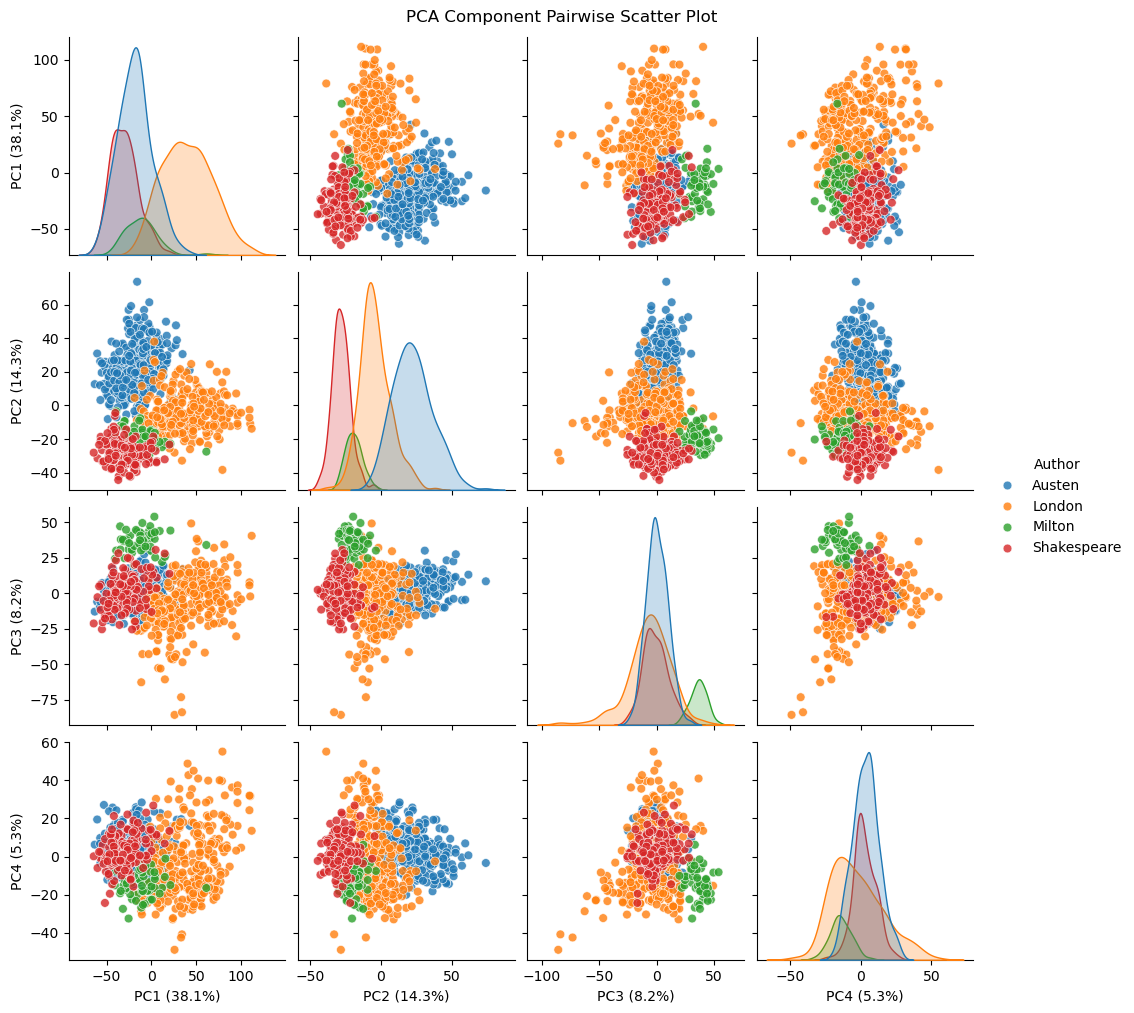

In [151]:
n = 4
pca_subset = pca_df_with_author[[f'PC{i+1}' for i in range(n)] + ['Author']] # Extract top-n PCs with author labels
explained = pca.explained_variance_ratio_[:n] * 100
pca_subset.columns = [f'PC{i+1} ({explained[i]:.1f}%)' for i in range(n)] + ['Author']

sns.pairplot(pca_subset, hue='Author', palette='tab10', corner=False, plot_kws={'alpha':0.8, 's':40})
plt.suptitle('PCA Component Pairwise Scatter Plot', y=1.01);


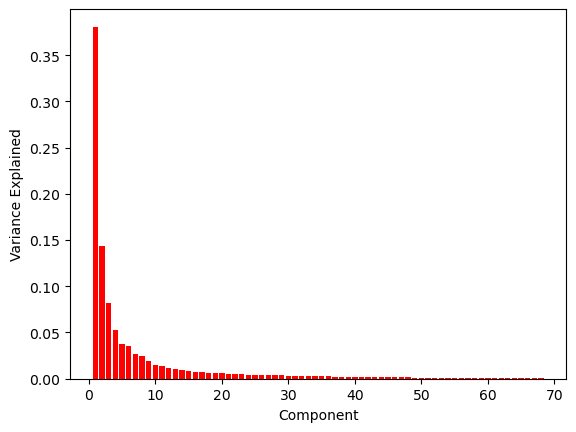

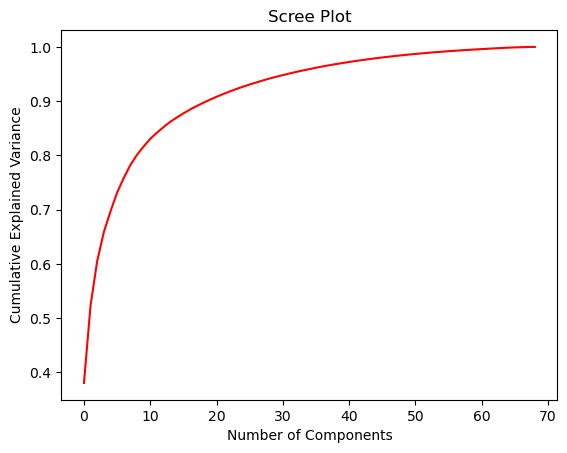

In [152]:
# Variance Explained Plot
plt.bar(np.arange(1, pca_df.shape[1]),pca.explained_variance_ratio_[0:pca_df.shape[1]-1], color = 'red')
plt.xlabel('Component')
plt.ylabel('Variance Explained')
plt.show()

# Screeplot
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'red')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

PCA is nested and ordered meaning the most variance explained is given by PC1, and the second most is PC2 and so on.

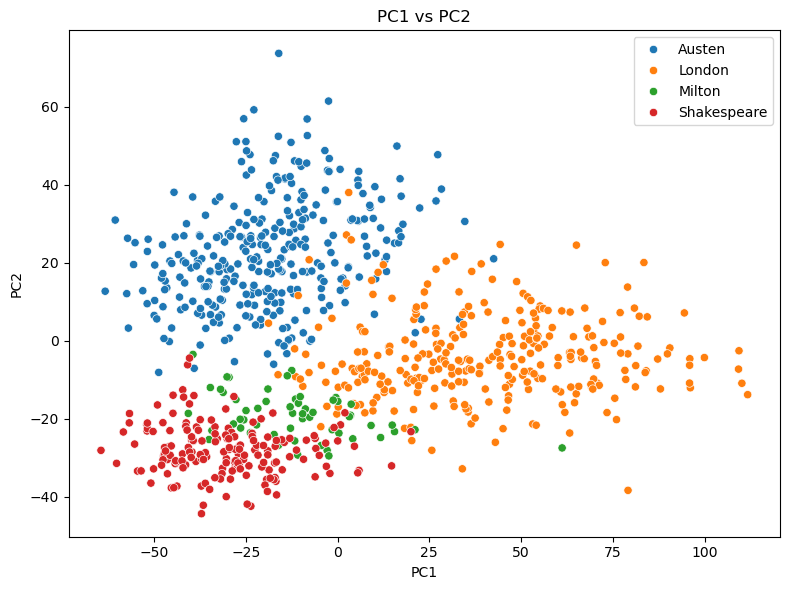

In [153]:
# Best Plot for PCA; LARGEST VARIANCE EXPLAINED
x, y = 'PC1', 'PC2' #adjust here
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df_with_author, x=x, y=y, hue='Author', palette='tab10', alpha=1)
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{x} vs {y}')
plt.legend(loc='upper right')
plt.tight_layout();


## PCA on Features

Features == Words

To do this we must transpose our dataframe and then apply the same methods as we have already done.

In [154]:
X_transpose = X.T
X_transpose = X_transpose.rename(columns = {i:f'Chapter{i}' for i in range(X_transpose.shape[1])})
X_transpose

,Chapter0,Chapter1,Chapter2,Chapter3,Chapter4,Chapter5,Chapter6,Chapter7,Chapter8,Chapter9,...,Chapter831,Chapter832,Chapter833,Chapter834,Chapter835,Chapter836,Chapter837,Chapter838,Chapter839,Chapter840
a,46,35,46,40,29,27,34,38,34,54,...,46,48,39,22,28,32,16,22,25,26
all,12,10,2,7,5,8,8,6,12,8,...,4,2,5,13,7,4,5,15,4,4
also,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
an,3,7,3,4,6,3,15,2,5,6,...,3,9,10,5,7,6,5,3,8,2
and,66,44,40,64,52,42,44,67,50,44,...,43,45,38,47,45,33,49,48,59,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
who,8,3,4,5,2,6,4,6,1,3,...,1,0,2,4,2,3,0,0,2,3
will,4,5,5,3,4,3,9,7,2,5,...,7,10,8,9,7,11,11,12,22,11
with,9,14,15,22,21,18,11,15,13,15,...,18,11,26,12,8,17,20,15,23,19
would,1,8,3,4,10,4,6,3,12,6,...,2,6,2,6,3,5,2,1,4,0


In [155]:
# Center the features
scaler = StandardScaler(with_std=False) #not scaling only centering
X_centered = scaler.fit_transform(X_transpose)

# Perform PCA on scaled data
pca = PCA()
pca_result = pca.fit_transform(X_centered)

pca_df = pd.DataFrame(pca_result)
pca_df
cols = [f'PC{j+1}' for j in range(pca_df.shape[1])]
pca_df = pca_df.rename(columns = {i:cols[i] for i in range(pca_df.shape[1])})

pca_df_words = pca_df.copy()
pca_df_words.index = X_transpose.index  # Use words as index
pca_df_words

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
a,586.050387,50.163435,35.008000,168.930205,-130.584023,73.261875,-29.813398,168.671326,-61.911809,21.158393,...,-0.028808,0.113269,1.092135,-0.201903,0.262726,1.107467,0.267015,-0.722587,0.179808,-1.770472e-13
all,-37.056676,-10.180601,-16.920965,-30.520113,3.085172,20.370336,20.955037,-0.813120,17.153739,30.872873,...,0.383836,-1.896502,-0.728495,-0.148027,0.496899,0.136251,-1.388524,0.477743,0.099273,-1.770472e-13
also,-275.839489,-61.225551,6.542485,-19.703686,9.328641,-2.643178,-3.371529,0.617304,0.584185,6.107842,...,0.712761,1.037531,0.474338,0.035060,0.788778,3.461856,4.778726,-4.906359,21.112972,-1.770472e-13
an,-104.140778,-88.729476,66.332678,99.893861,-71.260129,68.939655,106.172522,50.921177,67.834993,33.808069,...,0.975580,-0.991620,0.662421,0.262686,-0.909937,0.085531,-0.275755,-0.024427,0.196647,-1.770472e-13
and,1382.039964,83.594605,-205.254255,-236.146710,-59.203247,104.908651,-128.422484,0.908687,-10.144823,34.286019,...,0.052213,0.191897,-0.085089,0.037987,-0.020694,0.412064,-0.036710,0.047517,0.012894,-1.770472e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
who,-196.515788,-39.201310,-7.834830,-34.170276,11.928960,-1.666978,2.402290,-0.833140,-4.003598,14.434970,...,4.150651,-6.933739,-2.684091,-1.327385,-3.544767,0.868296,-2.969765,2.022023,-1.157411,-1.770472e-13
will,-163.405364,20.899231,-65.458337,30.432454,19.277051,8.046761,-2.666711,-30.745087,-22.235191,-5.186976,...,-1.147283,0.539559,-0.894122,0.218372,-2.533878,-0.526107,0.265318,-0.601183,-0.176481,-1.770472e-13
with,117.773657,29.506734,-56.978315,-56.128898,-25.663028,42.057283,43.679642,17.993353,18.300923,-6.102379,...,0.004423,-0.449697,0.140373,0.345507,0.482392,-0.165196,-0.455603,-0.195493,0.008405,-1.770472e-13
would,-155.766334,15.342778,31.947285,8.771575,5.470745,-8.483044,-16.765466,-16.416750,-17.988385,8.851434,...,1.218601,-0.257285,0.432577,0.955203,-1.526013,-0.270182,0.440711,0.786147,-0.240139,-1.770472e-13


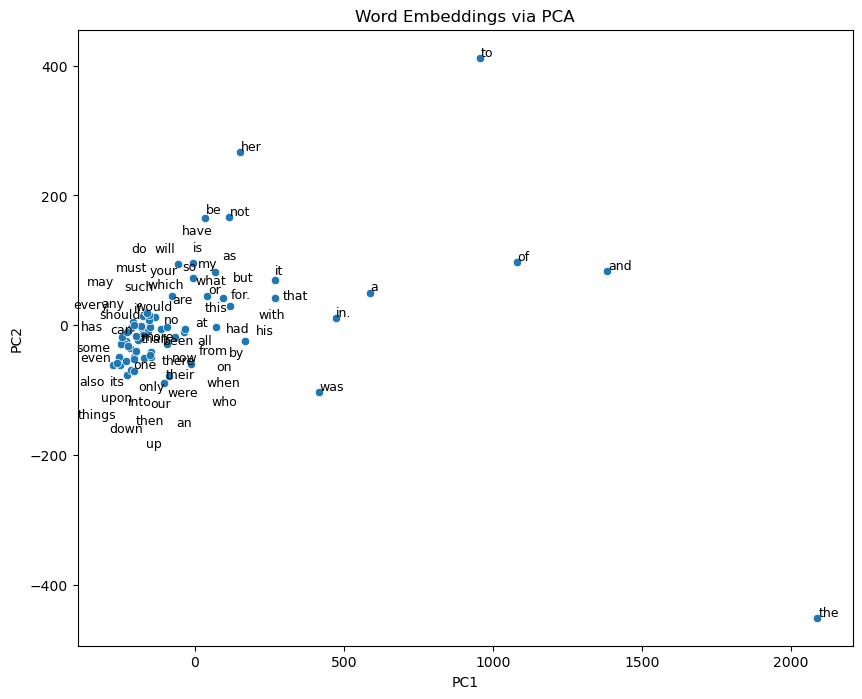

In [156]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df_words, x='PC1', y='PC2')
texts = [plt.text(pca_df_words.iloc[i]['PC1'], pca_df_words.iloc[i]['PC2'], pca_df_words.index[i], fontsize=9)
         for i in range(len(pca_df_words))]
adjust_text(texts)
plt.title("Word Embeddings via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Filter and plot top words.

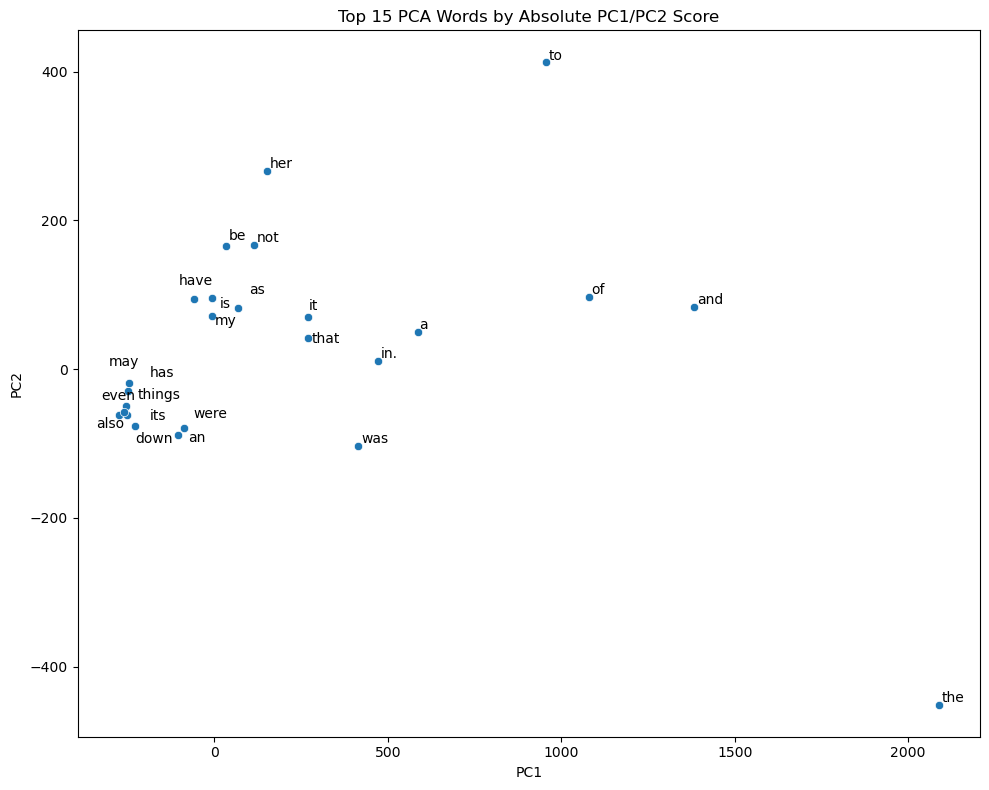

In [157]:
# Add word names
pca_df.index = X_transpose.index  # assign words as index
pca_df.columns = [f'PC{i+1}' for i in range(pca_df.shape[1])]

# Get top contributing words to PC1 and PC2
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
loadings.index = X_transpose.columns  # 841 chapters

# Now we want word *scores*, not loadings (we already have that in pca_df)
# So get top absolute PC values for words
top_words_pc1 = pca_df['PC1'].abs().sort_values(ascending=False).head(15).index
top_words_pc2 = pca_df['PC2'].abs().sort_values(ascending=False).head(15).index
top_words = top_words_pc1.union(top_words_pc2)

# Filter and plot
pca_df_filtered = pca_df.loc[top_words]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df_filtered, x='PC1', y='PC2')
texts = [plt.text(pca_df_filtered.iloc[i]['PC1'], pca_df_filtered.iloc[i]['PC2'],
                  pca_df_filtered.index[i], fontsize=10)
         for i in range(len(pca_df_filtered))]
adjust_text(texts)
plt.title("Top 15 PCA Words by Absolute PC1/PC2 Score")
plt.xlabel("PC1")
plt.ylabel("PC2")

# plt.gca().set_aspect('equal', adjustable='datalim') ##forces equal scale

plt.tight_layout()
plt.show()

This method offers poor visualization and little interpretability.  There are other methods that will provide more interpretability on the features such as NMF.

# NMF

## NMF on Observations

Observations == Book Chapters.

In [158]:
X_nmf = X + 1e-6 # Add a small constant to avoid zeros (NMF needs non-negative data)

# Run NMF with k topics
k = 3 # hyperparameter
model = NMF(n_components=k, init='random', random_state=0, max_iter=500)
W = model.fit_transform(X_nmf)  # shape: (69 words, k topics)
H = model.components_           # shape: (k topics, 841 chapters)

In [159]:

W_df = pd.DataFrame(W, index=X.index, columns=[f'Topic{i+1}' for i in range(k)]) # Turn W into a DataFrame with word labels
topic_df = W_df.reset_index(drop=True)
topic_df["Author"] = df["Author"].reset_index(drop=True)
topics = W_df.columns.tolist() # List of topic names
topic_pairs = list(combinations(topics, 2)) # All pairs of topics

Plotting all topic pairs yields the following.

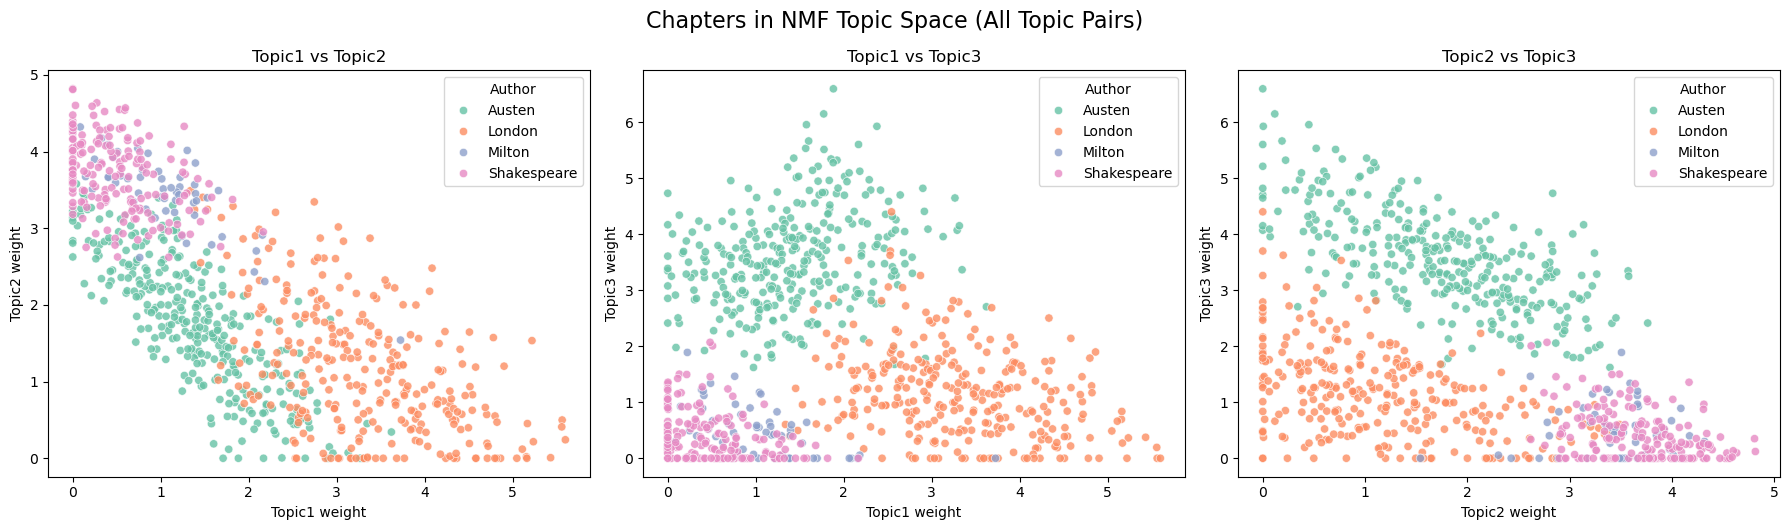

In [160]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

for i, (x_topic, y_topic) in enumerate(topic_pairs):
    ax = axes[i]
    sns.scatterplot(
        data=topic_df,
        x=x_topic, y=y_topic,
        hue="Author",
        palette="Set2",
        alpha=0.8,
        ax=ax
    )
    ax.set_title(f"{x_topic} vs {y_topic}")
    ax.set_xlabel(f"{x_topic} weight")
    ax.set_ylabel(f"{y_topic} weight")
    ax.legend().set_title("Author")

plt.tight_layout()
plt.suptitle("Chapters in NMF Topic Space (All Topic Pairs)", fontsize=16, y=1.05)
plt.show()

Like PCA, the decision boundaries are not clear without the labels so this method does not yield the best results on the observations.

## NMF on Features

Features == Words.

Using NMF we are able to perform dimensionality reduction while finding interpretable patterns by grouping words that describe chapters by themes/topics.

In [161]:
X_transpose

,Chapter0,Chapter1,Chapter2,Chapter3,Chapter4,Chapter5,Chapter6,Chapter7,Chapter8,Chapter9,...,Chapter831,Chapter832,Chapter833,Chapter834,Chapter835,Chapter836,Chapter837,Chapter838,Chapter839,Chapter840
a,46,35,46,40,29,27,34,38,34,54,...,46,48,39,22,28,32,16,22,25,26
all,12,10,2,7,5,8,8,6,12,8,...,4,2,5,13,7,4,5,15,4,4
also,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
an,3,7,3,4,6,3,15,2,5,6,...,3,9,10,5,7,6,5,3,8,2
and,66,44,40,64,52,42,44,67,50,44,...,43,45,38,47,45,33,49,48,59,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
who,8,3,4,5,2,6,4,6,1,3,...,1,0,2,4,2,3,0,0,2,3
will,4,5,5,3,4,3,9,7,2,5,...,7,10,8,9,7,11,11,12,22,11
with,9,14,15,22,21,18,11,15,13,15,...,18,11,26,12,8,17,20,15,23,19
would,1,8,3,4,10,4,6,3,12,6,...,2,6,2,6,3,5,2,1,4,0


Now we run NMF and get two components, W and H.  
- W represents chapters x topics
- H represents topics x words

In [162]:
# Add a small constant to avoid zeros (NMF needs non-negative data)
X_nmf = X_transpose + 1e-6

# Run NMF with k topics
k = 4 # hyperparameter
model = NMF(n_components=k, init='random', random_state=0, max_iter=500)
W = model.fit_transform(X_nmf)  # shape: (69 words, k topics)
H = model.components_           # shape: (k topics, 841 chapters)

In [163]:
# Turn W into a DataFrame with labels
W_df = pd.DataFrame(W, index=X_transpose.index, columns=[f'Topic{i+1}' for i in range(k)])
W_df 

,Topic1,Topic2,Topic3,Topic4
a,12.703487,9.567095,0.483944,2.602374
all,1.079770,1.396586,2.248865,1.258959
also,0.229118,0.000000,0.144176,0.000000
an,4.549360,1.441845,0.000000,0.054374
and,9.307504,5.728211,17.722282,6.001697
...,...,...,...,...
who,0.059405,0.297646,1.169796,0.495165
will,0.000000,3.631641,0.258497,0.254086
with,0.746218,2.372410,4.244667,2.023698
would,0.484461,1.523643,0.000000,1.441098


In [164]:
# Turn H into a Dataframe with labels
H_df = pd.DataFrame(H)
H_df.columns = X_transpose.columns
H_df.index = [f'Topic{i}' for i in range(1,k+1)]
H_df

,Chapter0,Chapter1,Chapter2,Chapter3,Chapter4,Chapter5,Chapter6,Chapter7,Chapter8,Chapter9,...,Chapter831,Chapter832,Chapter833,Chapter834,Chapter835,Chapter836,Chapter837,Chapter838,Chapter839,Chapter840
Topic1,1.388966,1.406549,0.697125,1.341688,1.325401,0.606958,1.100097,1.038123,0.642489,1.109125,...,0.452674,0.064731,0.356161,0.000000,0.127045,0.000000,0.000000,0.000000,0.000000,0.004147
Topic2,0.009625,0.696674,1.926100,0.560298,1.205885,1.993447,1.558374,0.700953,1.326439,1.483529,...,2.290017,2.867645,2.365239,2.523490,2.126112,3.074310,2.331398,2.339809,2.365277,2.150821
Topic3,0.693948,0.407469,0.244815,1.406300,1.412570,0.901878,0.404283,1.671437,0.686905,0.534818,...,1.306350,0.814292,1.315700,1.414172,1.052886,0.415843,1.488557,1.559131,2.089887,2.400112
Topic4,5.035964,3.640911,2.708667,3.313697,2.078612,1.684179,2.091687,3.495083,3.473353,2.777374,...,0.431708,0.867872,0.000000,0.220475,1.281741,0.620481,1.091426,0.280570,0.236132,0.000000


Now lets interpret our topics.

In [165]:
top_words_per_topic = {}
top_n = 15
for topic in W_df.columns:
    top_words = W_df[topic].sort_values(ascending=False).head(top_n)
    top_words_per_topic[topic] = top_words.index.tolist()

summary_df = pd.DataFrame(top_words_per_topic)
summary_df #importance in ascending order!

,Topic1,Topic2,Topic3,Topic4
0,the,the,and,to
1,was,a,the,her
2,of,to,of,and
3,a,my,to,of
4,and,is,his,was
5,in.,of,in.,be
6,it,it,with,not
7,had,that,from,had
8,that,not,all,as
9,an,and,their,it


Topic 1 = Narritive/Descriptive (past tense)

Topic 2 = Reflective/Personal voice

Topic 3 = Relational

Topic 4 = Dialogue/Character-driven phrasing

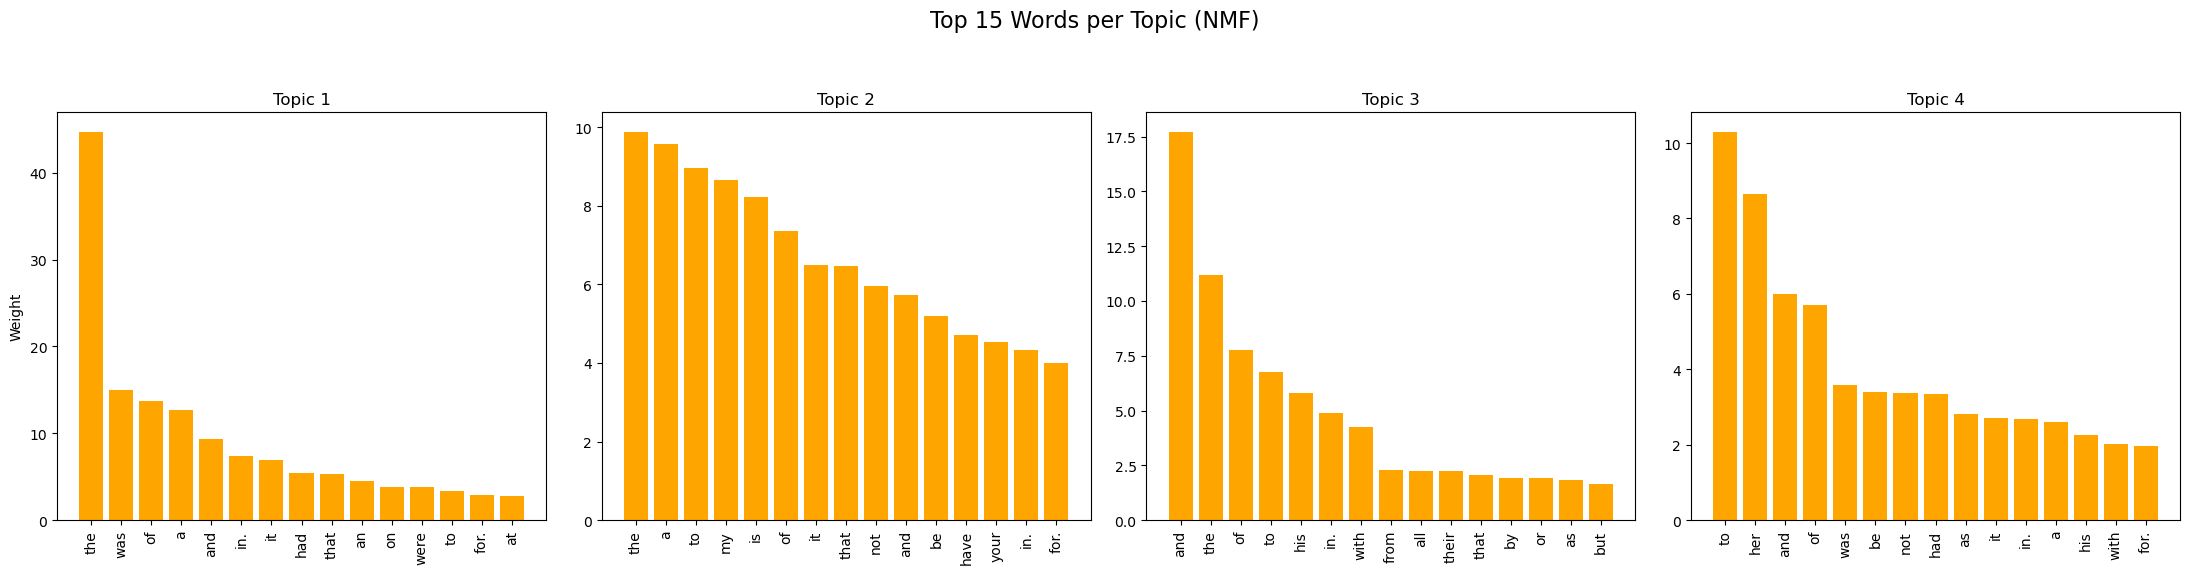

In [166]:
# visualize
topics = W_df.columns
fig, axes = plt.subplots(1, len(topics), figsize=(22, 6), sharey=False)

for i, topic in enumerate(topics):
    top_words = W_df[topic].sort_values(ascending=False).head(top_n)
    
    x = list(range(len(top_words)))
    axes[i].bar(x, top_words.values, color = 'orange')
    axes[i].set_title(f"Topic {i+1}")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(top_words.index, rotation=90)
    
    if i == 0:
        axes[i].set_ylabel("Weight")

plt.suptitle(f"Top {top_n} Words per Topic (NMF)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.93])

plt.savefig(fname = 'NMF topics')
plt.show()

Now lets determine which chapters correspond to which topics!

In [167]:
chapter_topic_df = H_df.T  # shape: (chapters × topics)
chapter_topic_df["Author"] = df['Author'].values
chapter_topic_df

,Topic1,Topic2,Topic3,Topic4,Author
Chapter0,1.388966,0.009625,0.693948,5.035964,Austen
Chapter1,1.406549,0.696674,0.407469,3.640911,Austen
Chapter2,0.697125,1.926100,0.244815,2.708667,Austen
Chapter3,1.341688,0.560298,1.406300,3.313697,Austen
Chapter4,1.325401,1.205885,1.412570,2.078612,Austen
...,...,...,...,...,...
Chapter836,0.000000,3.074310,0.415843,0.620481,Shakespeare
Chapter837,0.000000,2.331398,1.488557,1.091426,Shakespeare
Chapter838,0.000000,2.339809,1.559131,0.280570,Shakespeare
Chapter839,0.000000,2.365277,2.089887,0.236132,Shakespeare


In [168]:
# which author uses which topic more

author_topic_means = chapter_topic_df.groupby("Author").mean()
index_ = list(author_topic_means.index)
author_topic_means = author_topic_means.reset_index(drop=True)
author_topic_means.index = index_
author_topic_means

,Topic1,Topic2,Topic3,Topic4
Austen,0.887521,1.142230,0.867567,3.598350
London,1.858757,0.697897,1.918367,1.121614
Milton,0.258264,0.617670,3.870995,1.008754
Shakespeare,0.260634,2.244848,1.907850,0.338706


From this we can see that Austen heavily uses topic4; London uses topics 1,2,3; Milton heavily uses topic 3; Shakespeare is split between topic 2 and 3; 

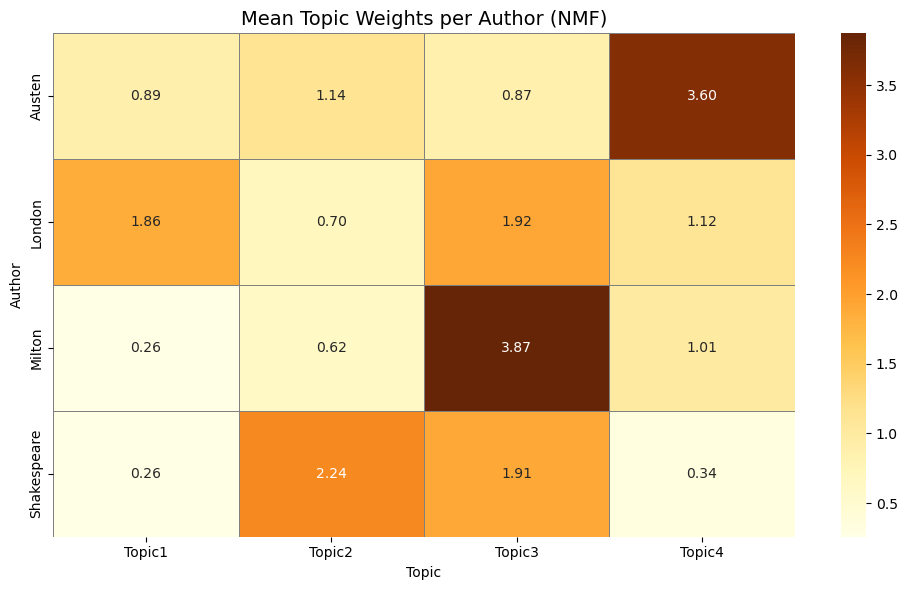

In [169]:
# Visualize these results

plt.figure(figsize=(10, 6))
sns.heatmap(author_topic_means, annot=True, fmt=".2f", cmap="YlOrBr",
            linewidths=0.5, linecolor='gray')

plt.title("Mean Topic Weights per Author (NMF)", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("Author")
plt.tight_layout()

# plt.savefig("author_topic_heatmap.png", dpi=300)

plt.show()
